# Image Analysis Lab

### Detect Normal or Abnormal Industrial Valves, Using Transfer Learning Technology upon Google's Pre-Trained Deep Neural Network


The use case here is to use drone to provide regular surveillance on remote or dangerous areas, capturing image of industrial equipment like valves, steam the data back for automatic malfunction diagnosis, using machine intelligence. This improves safety and efficiency compared to current human-involved processes, without large investment on fixed sensor infrastructure. The core part of this solution involves advanced image analysis in real world.


By: Sam Gu


May 2017


Reference: https://www.kernix.com/blog/image-classification-with-a-pre-trained-deep-neural-network_p11

### Let's have a look at the problem regarding real valve images, in 'images' directory:

### Normal Valves:

<img align="left" src='images/normal_valve_78.jpg' width=30%>
<img align="left" src='images/normal_valve_37.jpg' width=30%>
<img align="left" src='images/normal_valve_79.jpg' width=30%>

### Abormal Valves:

<img align="left" src='images/abnormal_valve_74.jpg' width=30%>
<img align="left" src='images/abnormal_valve_17.jpg' width=30%>
<img align="left" src='images/abnormal_valve_79.jpg' width=30%>

In [1]:
# Find out which file directory we are currently in:
!pwd

/content/datalab/GCP-SamGu/Lab


### Google's Inception-v3 Deep Neural Network Model

The pre-trained deep learning model that will be used is Inception-v3. It has been developed by Google and has been trained for the ImageNet Competition. We chose this model because of its high classification performance and because it is easily available in TensorFlow.

We have downloaded the pre-trained DCNN model at 'reference/reusable_model' directory.
If you want to re-download this model, run: !python reference/classify_image.py --model_dir reference/reusable_model

The customer's images are in the 'images' directory.

In [ ]:
# !python ./reference/classify_image.py --model_dir ./reference/reusable_model

### Start Deep Learning & Transfer Learning

In [2]:
import os
import re

import tensorflow as tf
import tensorflow.python.platform
from tensorflow.python.platform import gfile
import numpy as np
import pandas as pd
import sklearn
from sklearn import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
import matplotlib.pyplot as plt
%matplotlib inline
import pickle

In [15]:
model_dir = 'reference/reusable_model/'
images_dir = 'images/'
list_images = [images_dir+f for f in os.listdir(images_dir) if re.search('jpg|JPG', f)]

In [16]:
print('Number of Customer\'s Images       : %d' % len(list_images))

Number of Customer's Images       : 168


To use TensorFlow, you should define a graph that represents the description of computations. Then these computations will be executed within what is called sessions. If you want to know more about the basics of TensorFlow, you can go here.

The following function creates a graph from the graph definition that we just downloaded and that is saved in classify_image_graph_def.pb

In [23]:
def create_graph():
  with gfile.FastGFile(os.path.join(model_dir, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')

Then, the next step is to extract relevant features.

To do so, we retrieve the next-to-last layer of the Inception-v3 as a feature vector for each image. Indeed, the last layer of the convolutional neural network corresponds to the classification step: as it has been trained for the ImageNet dataset, the categories that it will be output will not correspond to the categories in the Product Image Classification dataset we are interested in.

The output of the next-to-last layer, however, corresponds to features that are used for the classification in Inception-v3. The hypothesis here is that these features can be useful for training another classification model, so we extract the output of this layer. In TensorFlow, this layer is called pool_3.

The following function returns the features corresponding to the output of this next-to-last layer and the labels for each image.

In [36]:
def extract_features(list_images):
  nb_features = 2048 # Deep Features
  features = np.empty((len(list_images),nb_features))
  labels = []

  create_graph()
  
  with tf.Session() as sess:
    next_to_last_tensor = sess.graph.get_tensor_by_name('pool_3:0')
    
    for ind, image in enumerate(list_images):
      if (ind%25 == 0):
        print('Processing %s...' % (image))
      if not gfile.Exists(image):
        tf.logging.fatal('File does not exist %s', image)
          
      image_data = gfile.FastGFile(image, 'rb').read()
      predictions = sess.run(next_to_last_tensor,
                             {'DecodeJpeg/contents:0': image_data})
      features[ind,:] = np.squeeze(predictions)
      labels.append(re.split('_\d+',image.split('/')[1])[0]) # Naming Convention: Class Lable + Digits + .jpg|JPG
          
    print('')
    print('Processing Completed !')
    return features, labels


In [35]:
features,labels = extract_features(list_images)

Processing images/abnormal_valve_78.jpg...
Processing images/normal_valve_03.jpg...
Processing images/normal_valve_80.jpg...
Processing images/normal_valve_27.jpg...
Processing images/abnormal_valve_21.jpg...
Processing images/abnormal_valve_64.jpg...
Processing images/abnormal_valve_17.jpg...
Processing Completed !


In [37]:
print('Number of Images                   : %d' % len(features))
print('Number of Deep Features per Images : %d' % len(features[0]))
print('Unique Image Classess (Labels)     : %s' % list(set(labels)))

Number of Images                   : 168
Number of Deep Features per Images : 2048
Unique Image Classess (Labels)     : ['abnormal_valve', 'normal_valve']


### WIP: Show Raw Pixels -> Deep Features

In [39]:
len(labels)

168

Then the features and labels are saved, so they can be used without re-running this step.

In [40]:
pickle.dump(features, open('features', 'wb'))
pickle.dump(labels, open('labels', 'wb'))

### Classification based on the features computed using TensorFlow

We will now use the features that we just computed with TensorFlow to train a classifier on the images. Another strategy could be to re-train the last layer of the CNN in TensorFlow, as shown here in TensorFlow tutorials and here for the python version.

### Prepare training and test datasets:

In [53]:
features = pickle.load(open('features'))
labels = pickle.load(open('labels'))

### We will use 80% of the data as the training set and 20% as the test set.

In [84]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(features, labels, test_size=0.2, random_state=42)


### Classifying the images with a Linear Support Vector Machine (SVM):
We chose to use a linear SVM to classify the images into the 2 categories using the features computed with TensorFlow. We used the LinearSVC implementation with the default parameters.

In [85]:
clf = LinearSVC(C=1.0, loss='squared_hinge', penalty='l2',multi_class='ovr')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

### Evaluation of Model Performance using Accuracy Score.

In [86]:
print("Accuracy: {0:0.1f}%".format(accuracy_score(y_test, y_pred)*100))

Accuracy: 94.1%


### Evaluation of Model Performance using Confusion Matrix

<img style="float: left;" width="60%" src="https://i.ytimg.com/vi/AOIkPnKu0YA/maxresdefault.jpg">

In [87]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
# import numpy as np

Confusion matrix of the classifier
[[13  0]
 [ 2 19]]


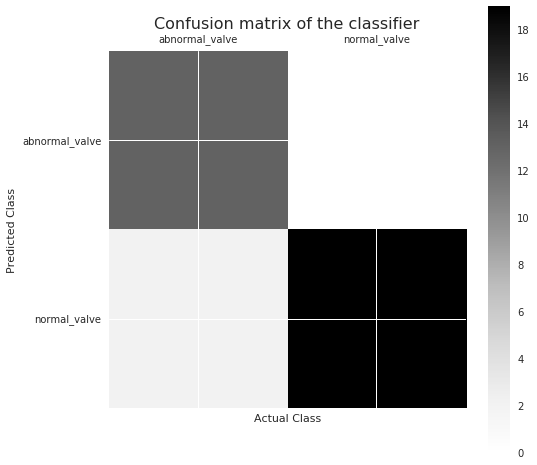

In [88]:
#Calculate Confusion matrix
cmlabels = list(set(labels))
# cm = confusion_matrix(np.array(y_test), y_pred)
cm = confusion_matrix(y_pred, y_test)
print('Confusion matrix of the classifier')
print(cm)

# Visualize Confusion matrix
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title(u'Confusion matrix of the classifier', fontsize=16)
fig.colorbar(cax)
ax.set_xticklabels([''] + cmlabels)
ax.set_yticklabels([''] + cmlabels)
plt.xlabel(u'Actual Class')
plt.ylabel(u'Predicted Class')
plt.show()

In [ ]:
labels[0]